# Plant Pathology Training Notebook

In [1]:
from fastai.vision.all import *
%config Completer.use_jedi = False

Set hyperparameters for the notebook here:

In [2]:
# Hyperparameters
valid_pct = 0.2

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/')
path.ls()

(#5) [Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/test_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/plant-pathology-2021-fgvc8.zip'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train.csv')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'train_images').ls()

(#18632) [Path('train_images/d7707b87601e9721.jpg'),Path('train_images/f1c0918f0b1ff4d8.jpg'),Path('train_images/9fd08acafc84e664.jpg'),Path('train_images/d4eccc89612723b7.jpg'),Path('train_images/bc287d94706dd853.jpg'),Path('train_images/90fc3c90d72f05f4.jpg'),Path('train_images/b5d7d2cdcf0d0c04.jpg'),Path('train_images/e07485de9fbca409.jpg'),Path('train_images/a7b91490d7de5a82.jpg'),Path('train_images/dce254af368e2658.jpg')...]

In [6]:
(path/'test_images').ls()

(#3) [Path('test_images/c7b03e718489f3ca.jpg'),Path('test_images/85f8cb619c66b863.jpg'),Path('test_images/ad8770db05586b59.jpg')]

The labels of the training images are in `train.csv` which has a space delimited list of labels for each image.

In [7]:
df = pd.read_csv(path/'train.csv')
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


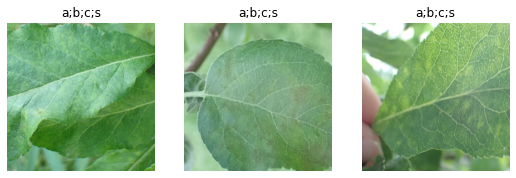

In [8]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct, seed=42),
    item_tfms=RandomResizedCrop(540, min_scale=0.35)
)

# dsets = dblock.datasets(df)
# dsets.train[0]
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [9]:
learn = cnn_learner(dls, arch=resnet18)

/media/xar/barracuda1/fast.ai/conda-lab3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
x,y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 22])

In [11]:
activations[0]

tensor([-1.4297,  1.5535, -1.4744, -1.0046,  0.5873,  1.6784,  0.1728,  0.1189,
        -2.6695,  1.5641,  0.8986,  1.4272, -0.7726,  0.1801, -2.1431, -3.6517,
         0.0332, -0.2411,  1.3362, -2.0044,  2.1636, -1.2890],
       grad_fn=<SelectBackward>)

In [12]:
loss_func = nn.BCEWithLogitsLoss()

In [13]:
loss_func(activations, y)

TensorMultiCategory(1.0491, grad_fn=<AliasBackward>)

### Fine-tune a Resnet18

SuggestedLRs(valley=0.0012022644514217973)

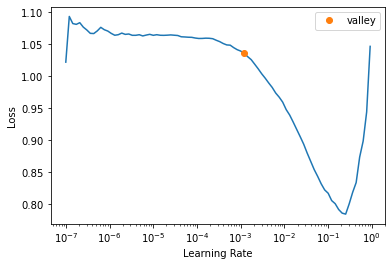

In [14]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   )

lrValley = learn.lr_find()
lrValley

In [15]:
learn.fine_tune(10, base_lr=lrValley.valley, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,0.787887,0.562145,0.579696,12:16
1,0.474593,0.316418,0.757479,12:53
2,0.289505,0.229476,0.792226,12:29
3,0.239692,0.195258,0.822383,12:28


epoch,train_loss,valid_loss,f1_score,time
0,0.190573,0.163580,0.852607,12:33
1,0.171200,0.142992,0.869531,12:38
2,0.149346,0.128800,0.880886,12:34
3,0.130844,0.122342,0.883990,12:32
4,0.108305,0.120962,0.888559,12:33
5,0.097977,0.119610,0.902565,12:34
6,0.084119,0.117861,0.907696,12:35
7,0.069609,0.119975,0.907856,12:36
8,0.064402,0.120309,0.908680,12:35
9,0.062825,0.120589,0.908986,12:36


In [16]:
learn.export('plant_resnet18.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet18.pkl') # load the model

### Fine-tune a Resnet34

SuggestedLRs(valley=0.0014454397605732083)

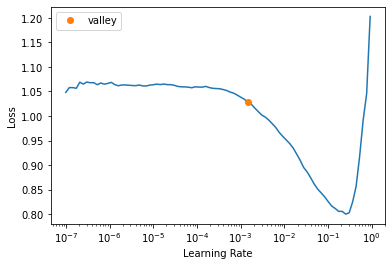

In [18]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   ).to_fp16()

lrValley = learn.lr_find()
lrValley

In [19]:
learn.fine_tune(10, base_lr=lrValley.valley, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,0.763138,0.526857,0.601060,12:34
1,0.423496,0.276008,0.776515,12:34
2,0.266440,0.202628,0.811854,12:35
3,0.229762,0.178090,0.831598,12:33


epoch,train_loss,valid_loss,f1_score,time
0,0.170743,0.136507,0.867804,12:48
1,0.147330,0.127906,0.885726,12:43
2,0.140608,0.121691,0.889971,12:42
3,0.121560,0.121264,0.886805,12:44
4,0.102823,0.119007,0.896019,12:42
5,0.080805,0.123225,0.890652,12:43
6,0.066777,0.119120,0.905036,12:43
7,0.050654,0.127903,0.903624,12:42
8,0.042290,0.126662,0.904584,12:39
9,0.040377,0.128954,0.903363,12:41


In [20]:
learn.export('plant_resnet34.pkl') # save the model

In [21]:
learn = load_learner('plant_resnet34.pkl') # load the model

### Fine-tune a Resnet50

SuggestedLRs(valley=0.0006918309954926372)

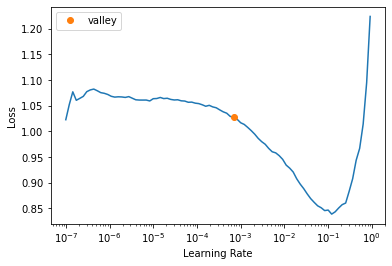

In [22]:
dls = dblock.dataloaders(df, bs=32)

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   ).to_fp16()

lrValley = learn.lr_find()
lrValley

In [23]:
learn.fine_tune(10, base_lr=lrValley.valley, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,0.673857,0.492392,0.628441,13:26
1,0.403862,0.260310,0.802595,13:23
2,0.249109,0.183192,0.834452,13:25
3,0.212853,0.156813,0.849095,13:23


epoch,train_loss,valid_loss,f1_score,time
0,0.178558,0.132082,0.879625,16:42
1,0.154890,0.124534,0.892065,16:40
2,0.141739,0.125973,0.895435,16:41
3,0.120861,0.109766,0.892862,16:40
4,0.107963,0.108668,0.907884,16:39
5,0.090167,0.112661,0.906309,16:40
6,0.075168,0.110600,0.913503,16:40
7,0.065750,0.109514,0.912438,16:39
8,0.051218,0.112631,0.914939,16:40
9,0.048914,0.111233,0.915381,16:40


In [24]:
learn.export('plant_resnet50.pkl') # save the model

In [25]:
learn = load_learner('plant_resnet50.pkl') # load the model